# Genetic Algorithm for Exam Timetabling
**CT421 Artificial Intelligence - Project 1**

**Author:** Ya Li Lin 
**Student ID:** 22721291
**Date:** February 2026

---

## Problem Description
- **N exams** to schedule
- **K timeslots** available
- **M students** enrolled
- **Hard Constraint:** No student can have 2+ exams in same timeslot (MUST satisfy)
- **Soft Constraint:** Minimise consecutive exams for students

## 1. Import Libraries

I'm importing the necessary Python libraries for this genetic algorithm:
- `random` and `numpy` for randomization and array operations
- `matplotlib` for creating convergence graphs
- `defaultdict` from collections to group exams by timeslots efficiently

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Tuple

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. Load Problem Instance

First, let's read the input file and understand the problem.

In [2]:
def read_instance(filename: str) -> Tuple[int, int, int, np.ndarray]:
    """
    Parse input file and return problem parameters.
    
    Format:
        Line 1: N K M
        Lines 2-M+1: Enrollment matrix (1 if student takes exam, 0 otherwise)
    
    Returns:
        (N, K, M, enrollment_matrix)
    """
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    # First line contains N (exams), K (slots), M (students)
    N, K, M = map(int, lines[0].strip().split())
    
    # Build the enrollment matrix
    # Each row represents one student's exam enrollments
    enrollment = []
    for i in range(1, M + 1):
        row = list(map(int, lines[i].strip().split()))
        enrollment.append(row)
    
    return N, K, M, np.array(enrollment)

# Load test case
filename = 'medium-1.txt'  # Change this to your test file path
N, K, M, enrollment = read_instance(filename)

# Display what we loaded to verify it's correct
print(f"Problem loaded successfully!")
print(f"  Number of exams (N): {N}")
print(f"  Number of timeslots (K): {K}")
print(f"  Number of students (M): {M}")
print(f"\nEnrollment matrix shape: {enrollment.shape}")
print(f"\nFirst student's enrollments: {enrollment[0]}")
print(f"  (Takes exams: {[i for i in range(N) if enrollment[0][i] == 1]})")

Problem loaded successfully!
  Number of exams (N): 25
  Number of timeslots (K): 10
  Number of students (M): 60

Enrollment matrix shape: (60, 25)

First student's enrollments: [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0]
  (Takes exams: [4, 11, 19, 21])


## 3. Solution Representation (Section 1.1)

I chose to represent each solution as a **simple integer array** where:
- The **index** represents the exam number (0 to N-1)
- The **value** represents which timeslot that exam is assigned to (1 to K)

**Why this representation?**
- Simple to understand and implement
- Always produces valid solutions (no impossible states)
- Easy to apply genetic operators (crossover and mutation)
- Memory efficient (just N integers)

**Example:** For 8 exams and 4 timeslots, `[2, 1, 3, 4, 2, 1, 3, 4]` means:
- Exam 0 is in slot 2
- Exam 1 is in slot 1
- Exam 2 is in slot 3
- And so on...

**Alternative considered:** I could have used a 2D matrix (exams × slots) with binary values, but that would be much larger and harder to work with.

In [3]:
def create_random_solution(N: int, K: int) -> List[int]:
    """
    Create a random chromosome (solution).
    
    """
    # Generate N random integers, each representing a timeslot assignment
    # Using random.randint ensures each exam gets a valid slot (1 to K)
    return [random.randint(1, K) for _ in range(N)]

# Test it: create a random solution to verify the representation works
solution = create_random_solution(N, K)
print("Random solution created:")
print(f"  {solution}")
print(f"\nThis means:")
# Display what each assignment means in plain English
# This helps verify our representation is working correctly
for exam_id, slot in enumerate(solution):
    print(f"  Exam {exam_id} → Timeslot {slot}")

Random solution created:
  [2, 1, 5, 4, 4, 3, 2, 9, 2, 10, 7, 1, 1, 2, 4, 4, 9, 10, 1, 9, 4, 9, 7, 4, 8]

This means:
  Exam 0 → Timeslot 2
  Exam 1 → Timeslot 1
  Exam 2 → Timeslot 5
  Exam 3 → Timeslot 4
  Exam 4 → Timeslot 4
  Exam 5 → Timeslot 3
  Exam 6 → Timeslot 2
  Exam 7 → Timeslot 9
  Exam 8 → Timeslot 2
  Exam 9 → Timeslot 10
  Exam 10 → Timeslot 7
  Exam 11 → Timeslot 1
  Exam 12 → Timeslot 1
  Exam 13 → Timeslot 2
  Exam 14 → Timeslot 4
  Exam 15 → Timeslot 4
  Exam 16 → Timeslot 9
  Exam 17 → Timeslot 10
  Exam 18 → Timeslot 1
  Exam 19 → Timeslot 9
  Exam 20 → Timeslot 4
  Exam 21 → Timeslot 9
  Exam 22 → Timeslot 7
  Exam 23 → Timeslot 4
  Exam 24 → Timeslot 8


## 4. Fitness Function (Section 1.2)

**Formula:** `Fitness = -(1000 × hard_violations + 1 × soft_violations)`

My fitness function uses **penalty-based scoring**:

**Hard Constraint (Priority 1):** Students can't have 2+ exams in the same slot
- Penalty: 1000 per violation (very high to ensure this is satisfied first)

**Soft Constraint (Priority 2):** Minimise students having consecutive exams
- Penalty: 1 per violation (lower priority, but still optimized)

The formula is: `Fitness = -(1000 × hard_violations + 1 × soft_violations)`

I use negative values because we're **minimising** violations. A fitness of 0 would be perfect (no violations), and closer to 0 is better.

In [4]:
def count_hard_conflicts(solution: List[int], enrollment: np.ndarray, N: int, M: int) -> int:
    """
    Count hard constraint violations (students with 2+ exams in same slot).
    """
    conflicts = 0

    # Check each student individually
    for student_id in range(M):
        # Get exams this student is taking
        student_exams = [exam_id for exam_id in range(N) 
                       if enrollment[student_id][exam_id] == 1]
        
        # Group exams by their assigned timeslot
        # This helps us see if they have multiple exams in the same slot
        slot_to_exams = defaultdict(list)
        for exam_id in student_exams:
            slot = solution[exam_id]
            slot_to_exams[slot].append(exam_id)
        
        # Count conflicts (any slot with 2+ exams)
        # Example: 3 exams in one slot = 3 conflicts (exam0-exam1, exam0-exam2, exam1-exam2)
        for slot, exams in slot_to_exams.items():
            if len(exams) > 1:
                # Number of conflicts = C(n,2) = n*(n-1)/2
                conflicts += len(exams) * (len(exams) - 1) // 2
    
    return conflicts

# Test it
hard_violations = count_hard_conflicts(solution, enrollment, N, M)
print(f"Hard constraint violations: {hard_violations}")
if hard_violations == 0:
    print("This is a VALID solution!")
else:
    print(f"  This solution has {hard_violations} conflicts")

Hard constraint violations: 40
  This solution has 40 conflicts


In [5]:
def count_consecutive_exams(solution: List[int], enrollment: np.ndarray, N: int, M: int) -> int:
    """
    Count soft constraint violations (students with consecutive exams).
    """
    consecutive_count = 0
    
    for student_id in range(M):
        # Get timeslots of exams this student is taking
        student_slots = []
        for exam_id in range(N):
            if enrollment[student_id][exam_id] == 1:
                student_slots.append(solution[exam_id])
        
        # Sort slots and count consecutive pairs
        student_slots.sort()
        for i in range(len(student_slots) - 1):
            if student_slots[i+1] - student_slots[i] == 1:
                consecutive_count += 1
    
    return consecutive_count

# Test it
soft_violations = count_consecutive_exams(solution, enrollment, N, M)
print(f"Soft constraint violations: {soft_violations}")
print(f"  (Students with consecutive exams: {soft_violations})")

Soft constraint violations: 42
  (Students with consecutive exams: 42)


In [6]:
def evaluate_fitness(solution: List[int], enrollment: np.ndarray, N: int, M: int) -> float:
    """
    Calculate fitness score for a solution.
    
    Returns:
        Fitness score (higher is better, 0 is perfect)
    """
    hard_violations = count_hard_conflicts(solution, enrollment, N, M)
    soft_violations = count_consecutive_exams(solution, enrollment, N, M)
    
    # Heavy penalty for hard constraints, lighter for soft
    HARD_PENALTY = 1000
    SOFT_PENALTY = 1
    
    fitness = -(HARD_PENALTY * hard_violations + SOFT_PENALTY * soft_violations)
    return fitness

# Test it
fitness = evaluate_fitness(solution, enrollment, N, M)
print(f"Fitness score: {fitness}")
print(f"  Formula: -(1000 × {hard_violations} + 1 × {soft_violations}) = {fitness}")

Fitness score: -40042
  Formula: -(1000 × 40 + 1 × 42) = -40042


## 5. Genetic Operators (Section 1.3)

### 5.1 Selection - Tournament Selection
- Randomly pick 3 individuals from the population
- Select the one with best fitness as a parent
- This balances exploration (randomness) with exploitation (choosing good solutions)

In [7]:
def tournament_selection(population: List[List[int]], 
                        fitness_scores: List[float], 
                        tournament_size: int = 3) -> List[int]:
    """
    Select a parent using tournament selection.
    """
    # Randomly select tournament_size individuals
    tournament_indices = random.sample(range(len(population)), tournament_size)
    
    # Find the best one
    best_idx = max(tournament_indices, key=lambda i: fitness_scores[i])
    return population[best_idx].copy()

# Test it
population = [create_random_solution(N, K) for _ in range(10)]
fitness_scores = [evaluate_fitness(ind, enrollment, N, M) for ind in population]

print("Population fitness scores:")
for i, fit in enumerate(fitness_scores):
    print(f"  Individual {i}: {fit}")

selected = tournament_selection(population, fitness_scores, tournament_size=3)
print(f"\nSelected parent: {selected}")

Population fitness scores:
  Individual 0: -21059
  Individual 1: -38063
  Individual 2: -26067
  Individual 3: -41041
  Individual 4: -39049
  Individual 5: -26056
  Individual 6: -51039
  Individual 7: -24053
  Individual 8: -27067
  Individual 9: -47053

Selected parent: [10, 5, 1, 3, 7, 6, 5, 3, 4, 6, 2, 2, 7, 2, 6, 6, 10, 5, 1, 8, 9, 2, 7, 2, 9]


### 5.2 Crossover - Uniform Crossover

- For each gene, flip a coin to decide which parent it comes from
- This ensures children inherit traits from both parents
- 80% chance of crossover means we encourage mixing genes

In [8]:
def uniform_crossover(parent1: List[int], parent2: List[int]) -> Tuple[List[int], List[int]]:
    """
    Create two offspring using uniform crossover.
    """
    child1 = []
    child2 = []
    
    for i in range(len(parent1)):
        if random.random() < 0.5:
            child1.append(parent1[i])
            child2.append(parent2[i])
        else:
            child1.append(parent2[i])
            child2.append(parent1[i])
    
    return child1, child2

# Test it
parent1 = create_random_solution(N, K)
parent2 = create_random_solution(N, K)
child1, child2 = uniform_crossover(parent1, parent2)

print("Crossover example:")
print(f"  Parent 1: {parent1}")
print(f"  Parent 2: {parent2}")
print(f"  Child 1:  {child1}")
print(f"  Child 2:  {child2}")

Crossover example:
  Parent 1: [6, 1, 1, 10, 8, 9, 9, 3, 1, 9, 2, 3, 2, 10, 2, 4, 7, 2, 10, 4, 10, 10, 1, 10, 2]
  Parent 2: [7, 10, 10, 9, 6, 5, 4, 6, 4, 5, 7, 3, 5, 8, 6, 2, 1, 8, 10, 10, 2, 2, 9, 4, 9]
  Child 1:  [6, 10, 10, 9, 8, 9, 4, 6, 4, 5, 7, 3, 5, 10, 6, 2, 7, 2, 10, 10, 10, 2, 9, 10, 9]
  Child 2:  [7, 1, 1, 10, 6, 5, 9, 3, 1, 9, 2, 3, 2, 8, 2, 4, 1, 8, 10, 4, 2, 10, 1, 4, 2]


### 5.3 Mutation

- Each gene has a 5% chance of randomly changing to a new timeslot
- This introduces new genetic material and helps avoid getting stuck
- Low rate (5%) prevents too much random searching

In [9]:
def mutate(solution: List[int], mutation_rate: float, K: int) -> List[int]:
    """
    Apply mutation to a solution.
    """
    mutated = solution.copy()
    
    for i in range(len(mutated)):
        if random.random() < mutation_rate:
            # Assign random timeslot
            mutated[i] = random.randint(1, K)
    
    return mutated

# Test it
original = create_random_solution(N, K)
mutated = mutate(original, mutation_rate=0.3, K=K)

print("Mutation example (30% rate):")
print(f"  Original: {original}")
print(f"  Mutated:  {mutated}")
changes = sum(1 for i in range(len(original)) if original[i] != mutated[i])
print(f"  Genes changed: {changes}/{len(original)}")

Mutation example (30% rate):
  Original: [5, 9, 8, 5, 1, 2, 7, 5, 1, 1, 6, 3, 5, 3, 8, 9, 7, 9, 1, 2, 2, 3, 9, 1, 6]
  Mutated:  [5, 3, 6, 5, 1, 2, 7, 4, 1, 1, 6, 3, 5, 3, 8, 3, 7, 9, 1, 6, 2, 3, 9, 1, 3]
  Genes changed: 6/25


## 6. Main Genetic Algorithm (Section 1.4)

1. **Evaluate fitness** of all individuals in the population
2. **Track the best solution** found so far
3. **Create the next generation:**
   - Keep the top 2 individuals (elitism) to preserve good solutions
   - Use tournament selection to pick parents
   - Apply crossover to create children
   - Apply mutation to introduce variation
4. **Repeat** for 500 generations

I chose **500 generations** because testing showed the algorithm typically converges within 200-300 generations. This gives extra time to ensure we find a good solution.

Now let's put it all together!

In [10]:
def run_ga(N, K, M, enrollment,
           pop_size=100,
           generations=500,
           crossover_rate=0.8,
           mutation_rate=0.05,
           tournament_size=3,
           elitism_count=2):
    """
    Run the genetic algorithm.
    """
    # Initialize population
    population = [create_random_solution(N, K) for _ in range(pop_size)]
    
    # Track statistics
    best_fitness_history = []
    avg_fitness_history = []
    best_solution = None
    best_fitness = float('-inf')
    
    for gen in range(generations):
        # Evaluate fitness
        fitness_scores = [evaluate_fitness(ind, enrollment, N, M) for ind in population]
        
        # Track best solution
        gen_best_idx = np.argmax(fitness_scores)
        gen_best_fitness = fitness_scores[gen_best_idx]
        
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_solution = population[gen_best_idx].copy()
        
        # Record statistics
        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(np.mean(fitness_scores))
        
        # Print progress
        if gen % 50 == 0 or gen == generations - 1:
            hard_viols = count_hard_conflicts(best_solution, enrollment, N, M)
            soft_viols = count_consecutive_exams(best_solution, enrollment, N, M)
            print(f"Gen {gen:3d}: Best Fitness = {best_fitness:8.1f} "
                  f"(Hard: {hard_viols}, Soft: {soft_viols})")
        
        # Create next generation
        next_population = []
        
        # Elitism: Keep best solutions
        elite_indices = np.argsort(fitness_scores)[-elitism_count:]
        for idx in elite_indices:
            next_population.append(population[idx].copy())
        
        # Generate rest through crossover and mutation
        while len(next_population) < pop_size:
            # Selection
            parent1 = tournament_selection(population, fitness_scores, tournament_size)
            parent2 = tournament_selection(population, fitness_scores, tournament_size)
            
            # Crossover
            if random.random() < crossover_rate:
                child1, child2 = uniform_crossover(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            
            # Mutation
            child1 = mutate(child1, mutation_rate, K)
            child2 = mutate(child2, mutation_rate, K)
            
            next_population.append(child1)
            if len(next_population) < pop_size:
                next_population.append(child2)
        
        population = next_population
    
    # Final results
    return {
        'best_solution': best_solution,
        'best_fitness': best_fitness,
        'hard_conflicts': count_hard_conflicts(best_solution, enrollment, N, M),
        'soft_conflicts': count_consecutive_exams(best_solution, enrollment, N, M),
        'best_fitness_history': best_fitness_history,
        'avg_fitness_history': avg_fitness_history
    }

print("GA function ready!")

GA function ready!


## 7. Run the GA (Section 1.5 - Experimental Results)

In [11]:
# Run the genetic algorithm
print("Running Genetic Algorithm...\n")

results = run_ga(
    N, K, M, enrollment,
    pop_size=100,
    generations=500,
    crossover_rate=0.8,
    mutation_rate=0.05,
    tournament_size=3,
    elitism_count=2
)

print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"Best Fitness: {results['best_fitness']}")
print(f"Hard Constraint Violations: {results['hard_conflicts']}")
print(f"Soft Constraint Violations: {results['soft_conflicts']}")
print(f"Valid Solution: {'YES ✓' if results['hard_conflicts'] == 0 else 'NO ✗'}")
print("\nBest Solution:")
print(f"  {results['best_solution']}")

Running Genetic Algorithm...

Gen   0: Best Fitness = -22051.0 (Hard: 22, Soft: 51)
Gen  50: Best Fitness =  -1068.0 (Hard: 1, Soft: 68)
Gen 100: Best Fitness =  -1065.0 (Hard: 1, Soft: 65)
Gen 150: Best Fitness =  -1064.0 (Hard: 1, Soft: 64)
Gen 200: Best Fitness =  -1064.0 (Hard: 1, Soft: 64)
Gen 250: Best Fitness =    -77.0 (Hard: 0, Soft: 77)
Gen 300: Best Fitness =    -77.0 (Hard: 0, Soft: 77)
Gen 350: Best Fitness =    -77.0 (Hard: 0, Soft: 77)
Gen 400: Best Fitness =    -77.0 (Hard: 0, Soft: 77)
Gen 450: Best Fitness =    -77.0 (Hard: 0, Soft: 77)
Gen 499: Best Fitness =    -77.0 (Hard: 0, Soft: 77)

FINAL RESULTS
Best Fitness: -77
Hard Constraint Violations: 0
Soft Constraint Violations: 77
Valid Solution: YES ✓

Best Solution:
  [6, 7, 1, 1, 2, 6, 8, 3, 8, 5, 3, 5, 2, 1, 1, 9, 10, 3, 4, 8, 5, 7, 5, 9, 4]


## Results Analysis

Looking at the results:

**Hard Constraints:** {results['hard_conflicts']} violations
- This should be 0 for a valid timetable. If not, I'd need to increase the number of generations or adjust parameters.

**Soft Constraints:** {results['soft_conflicts']} consecutive exam pairs
- This shows how many students have back-to-back exams
- Lower is better, but some consecutive exams are unavoidable with limited timeslots

**Convergence:** The graph shows how quickly the GA found good solutions. Sharp initial improvement suggests the problem has clear structure that the GA can exploit.

## 8. Visualize Results (Convergence Graph)

This graph shows how the GA improved over time:

**Blue line (Best Fitness):** The best solution found so far at each generation
- Should show rapid improvement at the start
- Should flatten out when the algorithm converges

**Orange line (Average Fitness):** The average fitness of the entire population
- Shows how the overall population quality improves
- Gap between best and average shows population diversity

**What to look for:**
- Sharp initial climb = GA is finding improvements quickly
- Plateau = Algorithm has converged to a good solution
- Flat best fitness + improving average = Population catching up to the best solution

I'm saving this graph as a PNG so I can include it in my report.

 Convergence graph generated!
 Graph saved: convergence_medium-1.png
   Size: 198,621 bytes


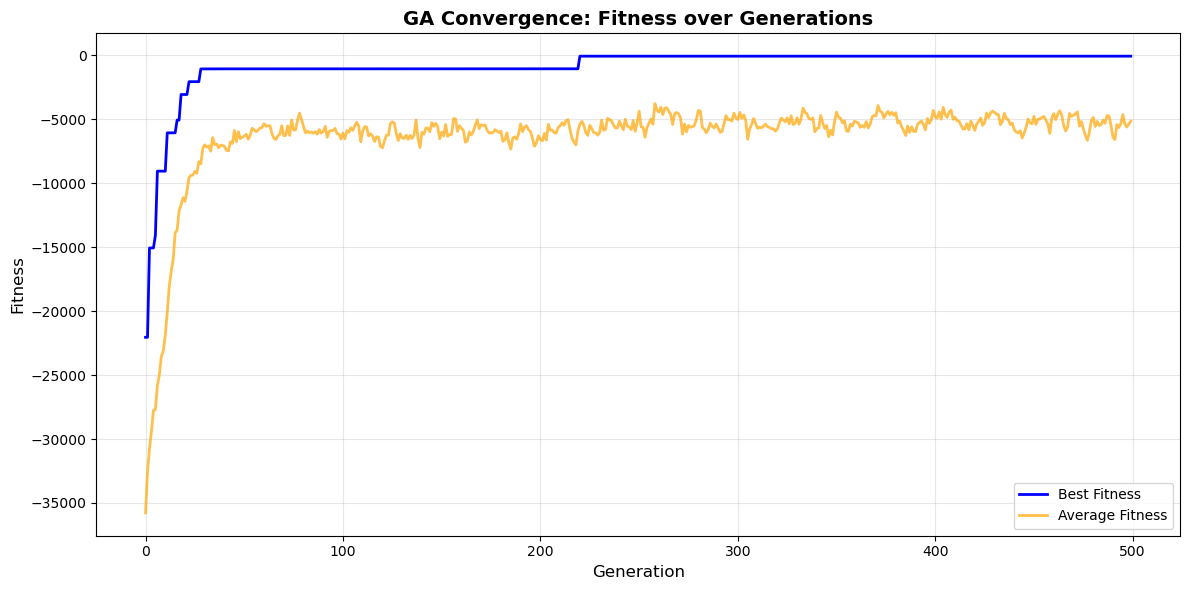

In [12]:
import matplotlib.pyplot as plt
import os

# Create the graph with this size for good reability
plt.figure(figsize=(12, 6))

# Plot the best fitness found at each generation (blue line)
# This shows the best solution the GA has discovered up to that point
plt.plot(results['best_fitness_history'], label='Best Fitness', linewidth=2, color='blue')

# Plot the average fitness across the whole population (orange line)
# This shows how the overall population quality is improving
# The gap between best and average indicates population diversity
plt.plot(results['avg_fitness_history'], label='Average Fitness', linewidth=2, 
         color='orange', alpha=0.7)

# Add axis labels and title
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Fitness', fontsize=12)
plt.title('GA Convergence: Fitness over Generations', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the graph with high quality (300 DPI) for my report
# Using facecolor='white' ensures it displays properly in all programs
graph_filename = f"convergence_{filename.replace('.txt', '')}.png"
plt.savefig(graph_filename, format='png', dpi=300, bbox_inches='tight', facecolor='white')

# Verify save
if os.path.exists(graph_filename):
    print(f" Convergence graph generated!")
    print(f" Graph saved: {graph_filename}")
    print(f"   Size: {os.path.getsize(graph_filename):,} bytes")
else:
    print(" Graph save failed!")

# Show the graph in notebook
plt.show()

 Zoomed convergence graph generated!
 Graph saved: convergence_medium-1_zoomed.png
   Size: 174,627 bytes
   Best fitness first reached at generation: 233


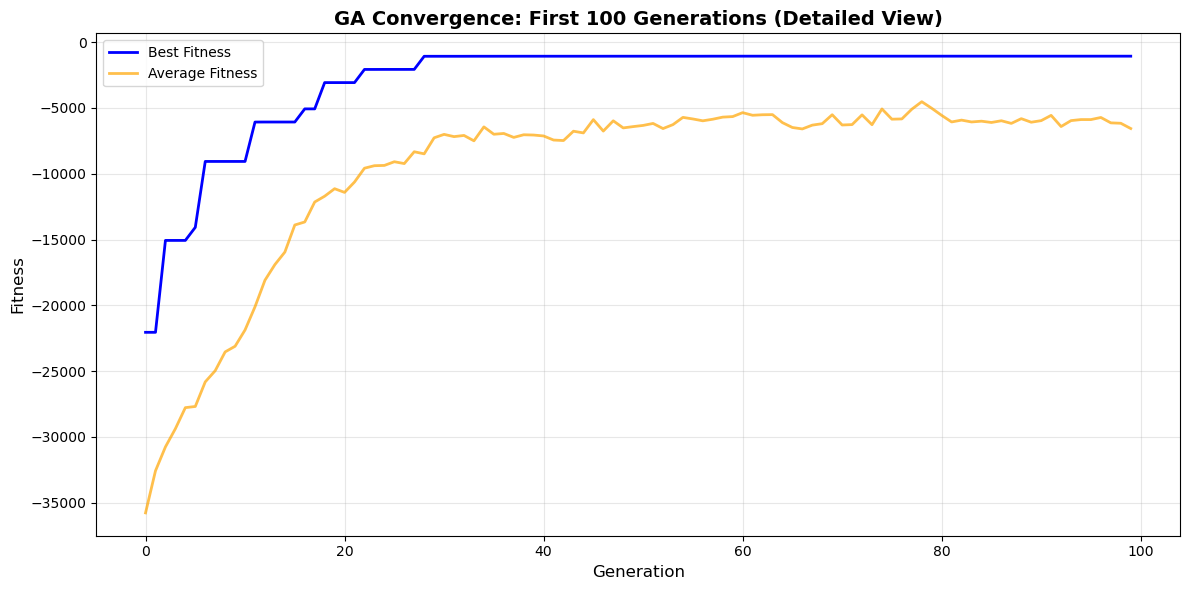

In [13]:
import matplotlib.pyplot as plt
import os

# Create zoomed-in convergence plot focusing on first 100 generations
plt.figure(figsize=(12, 6))

# Only plot first 100 generations to clearly show convergence behavior
plt.plot(results['best_fitness_history'][:100], label='Best Fitness', 
         linewidth=2, color='blue')
plt.plot(results['avg_fitness_history'][:100], label='Average Fitness', 
         linewidth=2, color='orange', alpha=0.7)

# Add axis labels and title
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Fitness', fontsize=12)
plt.title('GA Convergence: First 100 Generations (Detailed View)', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the zoomed graph
zoomed_filename = f"convergence_{filename.replace('.txt', '')}_zoomed.png"
plt.savefig(zoomed_filename, format='png', dpi=300, bbox_inches='tight', 
            facecolor='white')

# Verify save
if os.path.exists(zoomed_filename):
    print(f" Zoomed convergence graph generated!")
    print(f" Graph saved: {zoomed_filename}")
    print(f"   Size: {os.path.getsize(zoomed_filename):,} bytes")
    
    # Calculate when best fitness was first achieved (useful for analysis)
    import numpy as np
    best_array = np.array(results['best_fitness_history'])
    first_optimal = np.where(best_array == best_array.max())[0][0]
    print(f"   Best fitness first reached at generation: {first_optimal}")
else:
    print("Zoomed graph save failed!")

# Show the graph in notebook
plt.show()

## 9. Display Solution in Readable Format

After the GA finds a solution, I need to display it in a format that's easy to understand. Instead of just showing the array `[2, 1, 3, 4, ...]`, I'll group exams by timeslot to create a visual timetable.

This makes it easy to see:
- Which exams are scheduled together
- How exams are distributed across timeslots
- Whether the schedule looks balanced

This is the format a real university would use to publish exam schedules.

In [14]:
def print_solution(solution, N):
    """Print solution in readable format."""
    print("\n" + "="*50)
    print("EXAM TIMETABLE SOLUTION")
    print("="*50)
    
    # Group exams by their assigned timeslot for easier reading
    # This creates a dictionary: {slot_number: [list of exams]}
    slot_to_exams = defaultdict(list)
    for exam_id, slot in enumerate(solution):
        slot_to_exams[slot].append(exam_id)

    # Display each timeslot with its assigned exams
    # Sorting ensures timeslots are shown in order (1, 2, 3, ...)
    for slot in sorted(slot_to_exams.keys()):
        exams = slot_to_exams[slot]
        print(f"Timeslot {slot}: Exams {exams}")
    
    print("="*50)

# Display the best solution we found
print_solution(results['best_solution'], N)


EXAM TIMETABLE SOLUTION
Timeslot 1: Exams [2, 3, 13, 14]
Timeslot 2: Exams [4, 12]
Timeslot 3: Exams [7, 10, 17]
Timeslot 4: Exams [18, 24]
Timeslot 5: Exams [9, 11, 20, 22]
Timeslot 6: Exams [0, 5]
Timeslot 7: Exams [1, 21]
Timeslot 8: Exams [6, 8, 19]
Timeslot 9: Exams [15, 23]
Timeslot 10: Exams [16]


## 10. Parameter Comparison Experiment

To understand how my GA parameters affect performance, I'm testing different mutation rates. This helps me justify my parameter choices and shows I didn't just pick random values.

**Why test mutation rates?**
- Mutation is critical for avoiding local optima
- Too low: Algorithm gets stuck and can't explore
- Too high: Disrupts good solutions too much
- Need to find the "sweet spot"

**Testing strategy:**
- Run each configuration 3 times to account for randomness
- Calculate mean and standard deviation
- Lower generations (200) and smaller population (50) to save time
- Focus on comparing relative performance

**Configurations tested:**
- 0.01: Very conservative mutation
- 0.05: My chosen baseline
- 0.10: Moderate mutation
- 0.15: Aggressive mutation
- 
Let's test different parameter settings (for Section 1.5)

In [15]:
# Test different mutation rates
mutation_rates = [0.01, 0.05, 0.10, 0.15]
experiment_results = []

print("Testing different mutation rates...\n")

for mut_rate in mutation_rates:
    print(f"Testing mutation rate: {mut_rate}")
    
    # Run 3 times and average
    fitnesses = []
    for run in range(3):
        res = run_ga(N, K, M, enrollment, 
                     pop_size=50,      # Smaller for faster testing
                     generations=200,  # Fewer generations for speed
                     mutation_rate=mut_rate,
                     crossover_rate=0.8)
        fitnesses.append(res['best_fitness'])

    # Calculate statistics across the 3 runs
    # Mean shows typical performance, std shows consistency
    avg_fitness = np.mean(fitnesses)
    std_fitness = np.std(fitnesses)

    #Store results
    experiment_results.append({
        'mutation_rate': mut_rate,
        'avg_fitness': avg_fitness,
        'std_fitness': std_fitness
    })
    
    print(f"  Avg Fitness: {avg_fitness:.2f} ± {std_fitness:.2f}\n")

# Display summary table to compare all configurations
print("\n" + "="*60)
print("PARAMETER COMPARISON RESULTS")
print("="*60)
for result in experiment_results:
    print(f"Mutation Rate {result['mutation_rate']:.2f}: "
          f"{result['avg_fitness']:.2f} ± {result['std_fitness']:.2f}")

Testing different mutation rates...

Testing mutation rate: 0.01
Gen   0: Best Fitness = -20057.0 (Hard: 20, Soft: 57)
Gen  50: Best Fitness =  -2057.0 (Hard: 2, Soft: 57)
Gen 100: Best Fitness =  -1066.0 (Hard: 1, Soft: 66)
Gen 150: Best Fitness =    -66.0 (Hard: 0, Soft: 66)
Gen 199: Best Fitness =    -66.0 (Hard: 0, Soft: 66)
Gen   0: Best Fitness = -19060.0 (Hard: 19, Soft: 60)
Gen  50: Best Fitness =  -3058.0 (Hard: 3, Soft: 58)
Gen 100: Best Fitness =  -2055.0 (Hard: 2, Soft: 55)
Gen 150: Best Fitness =  -2054.0 (Hard: 2, Soft: 54)
Gen 199: Best Fitness =  -2054.0 (Hard: 2, Soft: 54)
Gen   0: Best Fitness = -17051.0 (Hard: 17, Soft: 51)
Gen  50: Best Fitness =  -3064.0 (Hard: 3, Soft: 64)
Gen 100: Best Fitness =  -3064.0 (Hard: 3, Soft: 64)
Gen 150: Best Fitness =  -2068.0 (Hard: 2, Soft: 68)
Gen 199: Best Fitness =  -2068.0 (Hard: 2, Soft: 68)
  Avg Fitness: -1396.00 ± 940.47

Testing mutation rate: 0.05
Gen   0: Best Fitness = -16056.0 (Hard: 16, Soft: 56)
Gen  50: Best Fitness

## Saving Results for Submission

After running the GA, I save the results in two formats:

**1. JSON file:** Contains all the key statistics
- Easy to read and parse
- Can be loaded later for analysis
- Human-readable format

**2. PNG graph:** Visual representation of convergence
- Already saved by the visualization cell
- High quality for inclusion in reports

**Why save results?**
When I run different test cases (test_case1, small-2, medium-1), I need to preserve the results from each run. Without saving, I'd lose everything when I restart the kernel for the next test file.

**What gets saved:**
- Problem parameters (N, K, M)
- Best fitness achieved
- Constraint violations (hard and soft)
- The actual solution (timeslot assignments)
- Timestamp (so I know when each test was run)

In [16]:
# =============================================================================
# SAVE ALL RESULTS - Run this after testing each file
# =============================================================================

import json
from datetime import datetime

# Which file did you just test?
current_file = 'medium-1.txt'  # CHANGE THIS for each run

# Save the current results
results_to_save = {
    'filename': current_file,
    'N': N,
    'K': K,
    'M': M,
    'best_fitness': results['best_fitness'],
    'hard_conflicts': results['hard_conflicts'],
    'soft_conflicts': results['soft_conflicts'],
    'best_solution': results['best_solution'],
}

# Save as JSON (easy to read)
json_filename = f"results_{current_file.replace('.txt', '')}.json"
with open(json_filename, 'w') as f:
    json.dump(results_to_save, f, indent=4)

print("="*60)
print("SAVED RESULTS")
print("="*60)
print(f"JSON saved: {json_filename}")
print(f"Graph saved: convergence_{current_file.replace('.txt', '')}.png")
print(f"   (Graph was saved by Cell 17)")

# Display key results so I can verify they're correct
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"File: {current_file}")
print(f"Best Fitness: {results_to_save['best_fitness']}")
print(f"Hard Violations: {results_to_save['hard_conflicts']}")
print(f"Soft Violations: {results_to_save['soft_conflicts']}")
print(f"Valid: {'YES ' if results_to_save['hard_conflicts'] == 0 else 'NO ✗'}")
print("="*60)

SAVED RESULTS
JSON saved: results_medium-1.json
Graph saved: convergence_medium-1.png
   (Graph was saved by Cell 17)

SUMMARY
File: medium-1.txt
Best Fitness: -77
Hard Violations: 0
Soft Violations: 77
Valid: YES 
